# NOTEBOOK DEEPSEEK - MULTICLASS CLASSIFICATION (ZERO-SHOT)

This notebook evaluates the DeepSeek LLM using zero-shot prompting for multiclass classification, distinguishing between normal or the different types of attack.


## 1. OBJECTIVES

The objective of this notebook is to evaluate the performance of the DeepSeek LLM in a **zero-shot multiclass classification** setting.

Specifically, this notebook aims to:
- Test the model's ability to distinguish between **normal** and the **different types of attack** without prior examples.
- Analyze the model's predictions and assess its suitability for multiclass threat detection tasks in IoT systems.


## 2. IMPORTS AND SETUP
Import the required python libraries, preprocessing, and evaluation.

In [1]:
# pandas, json, re and os imports
import pandas as pd
import json
import os
import re
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# imports for LLM training
from datasets import Dataset, DatasetDict
from huggingface_hub import interpreter_login
from unsloth import FastLanguageModel
# imports for evaluation (sklearn)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# tqdm import
from tqdm import tqdm

# Login to Hugging Face Hub
interpreter_login()

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



## 3. PREPARE LLM

Load the DeepSeek language model from Unsloth with specific configuration parameters.


In [2]:
# Define model loading parameters
max_seq_length = 2048 
dtype = None 
load_in_4bit = True

# Load the DeepSeek LLM with Unsloth's FastLanguageModel utility
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/DeepSeek-R1-Distill-Llama-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4060 Laptop GPU. Max memory: 7.996 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


### Test one sample

In [3]:
# Sample IoT log entry to classify
log_entry = """
- The length of the DNS query is: 0.0
- The MQTT protocol name used is: 0.0
- The MQTT message type is: 0.0
- The MQTT topic is: 0.0
- The MQTT connection acknowledgment flags are: 0.0
- TCP options set in the packet are: 0101080a9b1f90b39ead21c3
- TCP destination port is: 80.0
"""

# Minimal and restrictive zero-shot prompt
question = f"""
Classify the following IoT log as one of these categories:

SQL_Injection, Fingerprinting, Vulnerability_Scanner, Normal, DDoS_UDP, DDoS_ICMP, DDoS_HTTP, DDoS_TCP, Uploading, MITM, Backdoor, Password, Ransomware, XSS, Port_Scanning

Do not explain. Only return one of the category names.

{log_entry.strip()}

Answer:"""


In [5]:
# Model is ready for inference
FastLanguageModel.for_inference(model)

# Tokenize the input
inputs = tokenizer([question], return_tensors="pt").to("cuda")

# Generate the model's response
outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=2,  
    use_cache=True
)

# Decode and extract response
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()

print("Model Response:", response)

Model Response: Classify the following IoT log as one of these categories:

SQL_Injection, Fingerprinting, Vulnerability_Scanner, Normal, DDoS_UDP, DDoS_ICMP, DDoS_HTTP, DDoS_TCP, Uploading, MITM, Backdoor, Password, Ransomware, XSS, Port_Scanning

Do not explain. Only return one of the category names.

- The length of the DNS query is: 0.0
- The MQTT protocol name used is: 0.0
- The MQTT message type is: 0.0
- The MQTT topic is: 0.0
- The MQTT connection acknowledgment flags are: 0.0
- TCP options set in the packet are: 0101080a9b1f90b39ead21c3
- TCP destination port is: 80.0

Answer: Normal


## 4. PREPARE DATASET

The dataset is split into 70% for training, 15% for validation, and 15% for testing. However, only the **test split** is used in this notebook for zero-shot evaluation. 

These results will later be compared with the outcomes from the few-shot and fine-tuning experiments.

In [6]:
# Define file path
file_path = "../../../data/prompts/multiclass_instructions.jsonl"

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# Read JSONL file line by line
samples = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        sample = json.loads(line.strip())  # Load each line as a JSON object
        samples.append({"text": sample["Prompt"]})  # Extract the prompt field

# Convert into Hugging Face Dataset format
dataset_dict = {"full": Dataset.from_list(samples)}
dataset = DatasetDict(dataset_dict)

# Verify first example
print(dataset["full"][0])

{'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.\n### Instruction:\nYou are a cybersecurity expert specializing in IoT security. Your task is to analyze network logs and determine whether the given log data indicates a potential attack. Only provide the type of attack if it is an attack. If the log data is normal traffic, state that it is normal traffic.\n### Question:\n- The length of the DNS query is: 0.0\n- The MQTT protocol name used is: 0.0\n- The MQTT message type is: 0.0\n- The MQTT topic is: 0.0\n- The MQTT connection acknowledgment flags are: 0.0\n- TCP options set in the packet are: 0101080a9eb23b7d9b24a80c\n- TCP destination port is: 44090.0\n### Response:\n<think>\nThis log data is an attack!! The type of attack detecte

In [7]:
# Shuffle the dataset
dataset = dataset["full"].shuffle(seed=42)

# Split dataset into train (70%), validation (15%), test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))

# Ensure the split sizes are correct
train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

# Print sizes
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

Train Samples: 10500
Validation Samples: 2250
Test Samples: 2250


## 5. DEFINE HELPER FUNCTIONS FOR PREDICTIONS

This section defines two helper functions:

- `extract_and_format_log_zero_shot`: Formats the input log into a prompt compatible with the LLM for the zero-shot prompting.
- `extract_true_label`: Extracts the true label associated with each input sample for evaluation.

In [8]:
# Zero-shot prompt generator
def extract_and_format_log_zero_shot(json_text):
    match = re.search(r'### Question:\n(.*?)### Response:', json_text, re.DOTALL)
    if not match:
        return None

    log_entry = match.group(1).strip()
    log_entry = "\n".join(line.strip() for line in log_entry.split("\n") if line.strip())

    # Zero-shot instruction
    instruction = f"""
You are a cybersecurity LLM trained to classify raw IoT network logs into one of the following categories:

SQL_Injection, Fingerprinting, Vulnerability_Scanner, Normal, DDoS_UDP, DDoS_ICMP, DDoS_HTTP, DDoS_TCP, Uploading, MITM, Backdoor, Password, Ransomware, XSS, Port_Scanning

Only output one of the category names. Do not explain or provide any additional text.

{log_entry}

Category:"""
    return instruction

In [9]:
# Extract the true label from the JSON text
def extract_true_label(json_text):
    match = re.search(r'This log data is (an attack!! The type of attack detected is |normal traffic)(.*?)(\.)', json_text, re.IGNORECASE)
    if match:
        attack_type = match.group(2).strip()
        return attack_type if attack_type else "Normal"
    return "Unknown"

## 6. COMPUTE PREDICTIONS

In this section, predictions are generated using the LLM and stored in a list. The corresponding true labels are also collected in a separate list. 

Both lists will be used later to compute evaluation metrics.

In [10]:
# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# List of possible attack categories (all lowercase for consistency)
attack_categories = [
    "sql_injection", "fingerprinting", "vulnerability_scanner", "normal",
    "ddos_udp", "ddos_icmp", "ddos_http", "ddos_tcp",
    "uploading", "mitm", "backdoor", "password", "ransomware",
    "xss", "port_scanning"
]

# Iterate over each sample in the test dataset
for sample in tqdm(test_dataset, desc="Processing test samples"):
    # Transform the log text into the required prompt format
    formatted_prompt = extract_and_format_log_zero_shot(sample["text"]) 
    true_label = extract_true_label(sample["text"])  

    # Normalize true label to lowercase
    true_label = true_label.lower().strip()

    # Skip invalid samples
    if not formatted_prompt or true_label == "unknown":
        continue  

    # Tokenize the input text
    inputs = tokenizer([formatted_prompt], return_tensors="pt").to("cuda")

    # Generate the model's response
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=1,  # Allow more space for category name
        use_cache=True
    )

    # Decode the model's output
    response_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()

    # Normalize the response text
    attack_categories_lower = [cat.lower() for cat in attack_categories]

    # Extract the last line of the response
    last_line = response_text.strip().split("\n")[-1].strip().lower()

    # Check if the last line matches any of the attack categories
    predicted_label = "unknown"
    for category in attack_categories:
        if category.lower() in last_line:
            predicted_label = category
            break

    # Append the predicted label and true label to the lists
    predictions.append(predicted_label)
    true_labels.append(true_label)

Processing test samples:   0%|          | 0/2250 [00:00<?, ?it/s]

Processing test samples: 100%|██████████| 2250/2250 [09:39<00:00,  3.89it/s]


## 7. Compute Evaluation Metrics

In this section, standard evaluation metrics are computed to assess the model's performance. These include the general Accuracy, Precision, Recall, F1-Score. Also, it includes the previous metrics for each class, except the accuracy, and the Confusion Matrix.

### GENERAL METRICS

In [11]:
# Compute global classification metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average="weighted", zero_division=0)
recall = recall_score(true_labels, predictions, average="weighted", zero_division=0)
f1 = f1_score(true_labels, predictions, average="weighted", zero_division=0)

# Print global summary results
print("Multi-Class Evaluation Results:")
print(f" -Accuracy: {accuracy:.4f}")
print(f" -Precision: {precision:.4f}")
print(f" -Recall: {recall:.4f}")
print(f" -F1 Score: {f1:.4f}")

Multi-Class Evaluation Results:
 -Accuracy: 0.0418
 -Precision: 0.0035
 -Recall: 0.0418
 -F1 Score: 0.0065


### METRICS PER CLASS

In [12]:
# Precision, Recall and F1 by class
precision_per_class = precision_score(true_labels, predictions, average=None, labels=attack_categories, zero_division=0)
recall_per_class = recall_score(true_labels, predictions, average=None, labels=attack_categories, zero_division=0)
f1_per_class = f1_score(true_labels, predictions, average=None, labels=attack_categories, zero_division=0)

# Display metrics per class
print("\n\nEvaluation per Class:")
for i, label in enumerate(attack_categories):
    print(f"{label:25s} | Precision: {precision_per_class[i]:.4f} | Recall: {recall_per_class[i]:.4f} | F1-score: {f1_per_class[i]:.4f}")



Evaluation per Class:
sql_injection             | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
fingerprinting            | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
vulnerability_scanner     | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
normal                    | Precision: 0.0511 | Recall: 0.6065 | F1-score: 0.0943
ddos_udp                  | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
ddos_icmp                 | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
ddos_http                 | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
ddos_tcp                  | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
uploading                 | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
mitm                      | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
backdoor                  | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
password                  | Precision: 0.0000 | Recall: 0.0000 | F1-score:

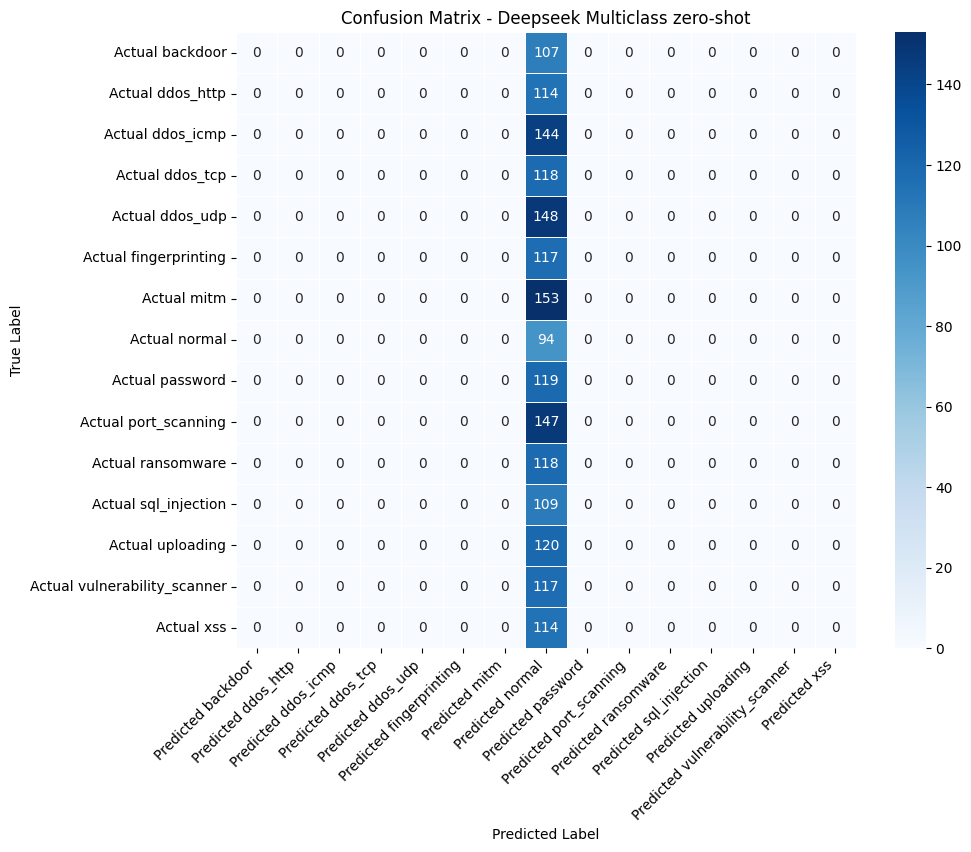

In [13]:
# Get unique labels from true data
unique_labels = sorted(set(true_labels)) 

# Compute confusion matrix for all attack types
cm = confusion_matrix(true_labels, predictions, labels=unique_labels)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=[f"Actual {label}" for label in unique_labels], 
                         columns=[f"Predicted {label}" for label in unique_labels])

# Plot the confusion matrix
plt.figure(figsize=(10,8))  
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Deepseek Multiclass zero-shot")
plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
plt.yticks(rotation=0)
plt.show()
